# Landscape detection

## Install dependencies

In [1]:
pip install -r ..\requirements

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob as gb
import cv2
import tensorflow as tf

In [3]:
trainpath = '../archive/seg_train/seg_train/'
testpath = '../archive/seg_test/seg_test/'
predpath = '../archive/seg_pred/seg_pred/'

## define data generator

In [4]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.9, 1.1)
)

## search for training data

In [5]:
IMG_HEIGHT, IMG_WIDTH = 150, 150
batch_size = 64

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=trainpath,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 14034 images belonging to 6 classes.


## found classes

In [6]:
print(train_data_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## display samples from training set

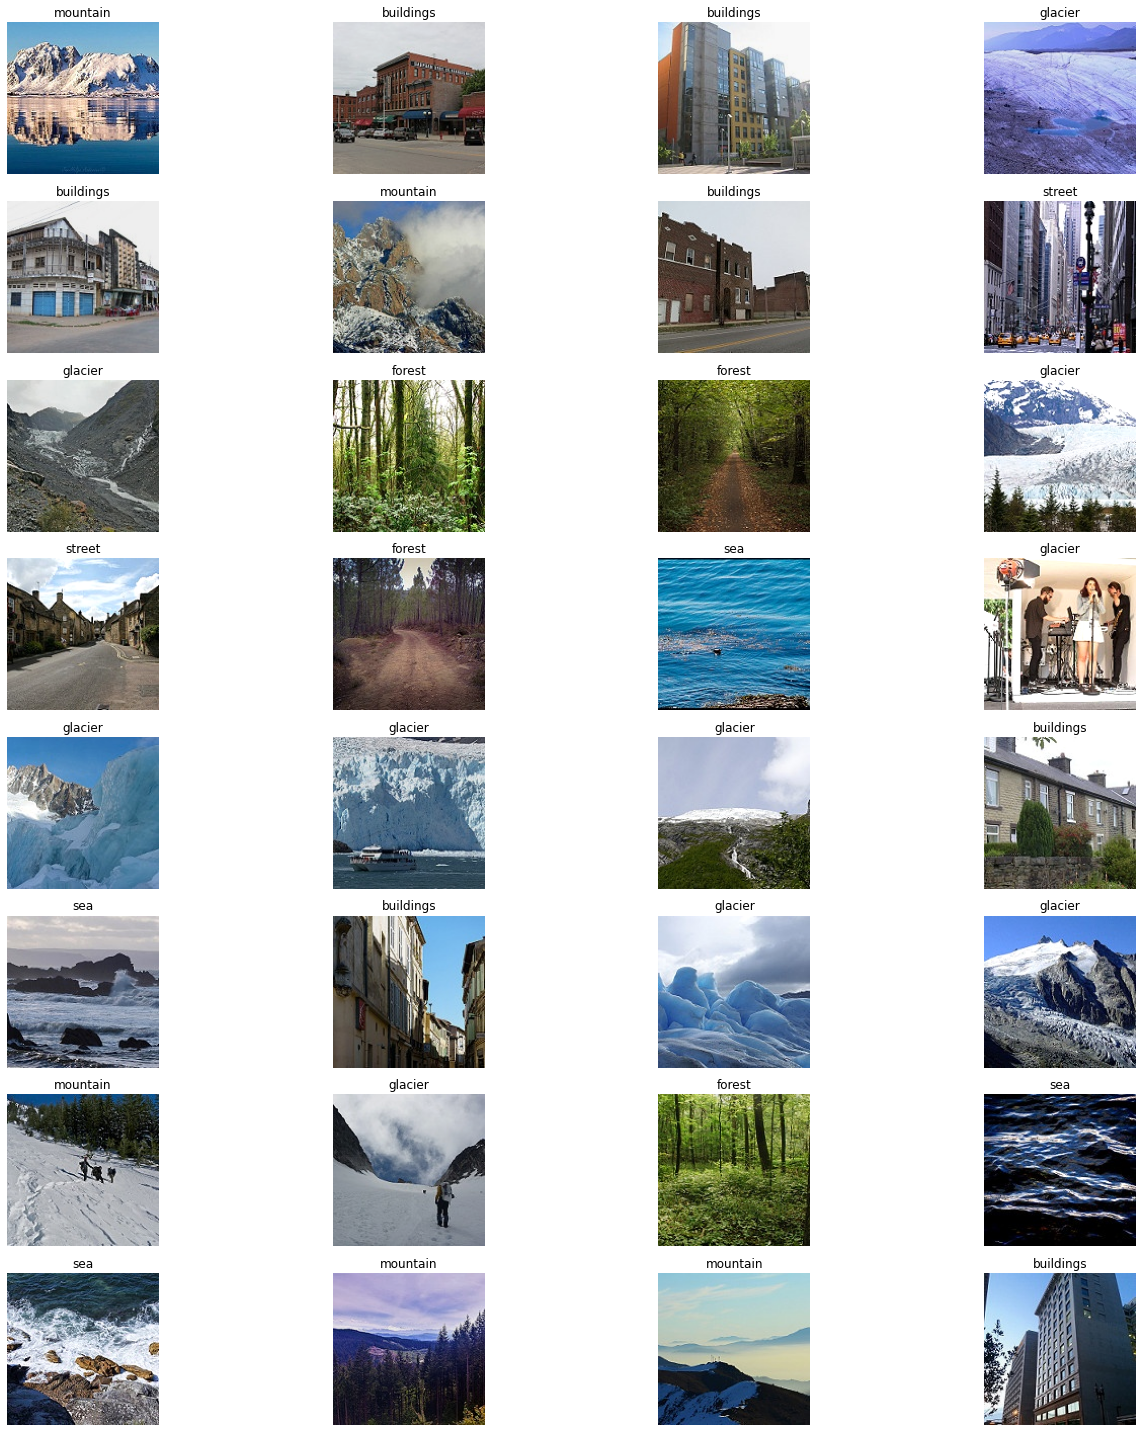

In [7]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

## load test data

In [8]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.9, 1.1)
)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=testpath,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 3000 images belonging to 6 classes.


In [9]:
print(test_data_gen.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


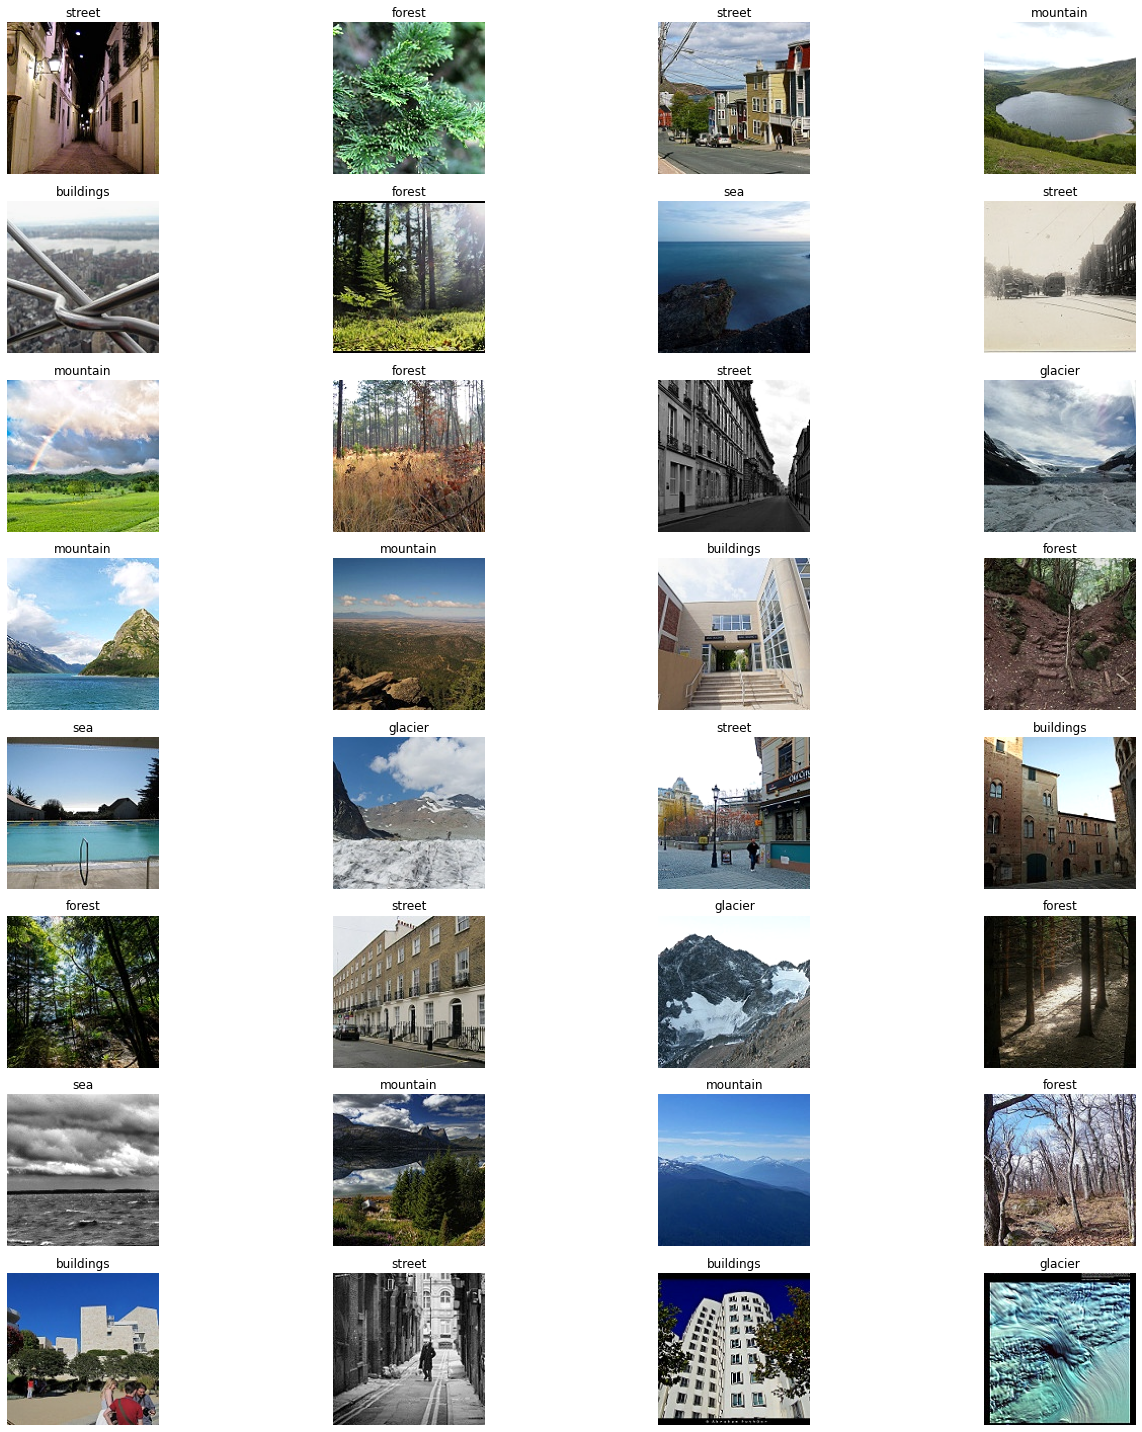

In [10]:
sample_test_images, labels = next(test_data_gen)
class_label = {v:k for k,v in test_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_test_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# train model

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        tf.keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        tf.keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        tf.keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(4,4),
        tf.keras.layers.Flatten() ,    
        tf.keras.layers.Dense(120,activation='relu') ,    
        tf.keras.layers.Dense(100,activation='relu') ,    
        tf.keras.layers.Dense(50,activation='relu') ,        
        tf.keras.layers.Dropout(rate=0.5) ,            
        tf.keras.layers.Dense(6,activation='softmax') ,   
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 150)     270150    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 150)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 120)       162120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 80)        86480     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 50)        36050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

In [13]:
model.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    train_data_gen,
    # steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=10 #use way more or use EarlyStopping callback
)

Epoch 1/10
220/220 [==============================] - 1880s 9s/step - loss: 1.2549 - accuracy: 0.5021
Epoch 2/10
220/220 [==============================] - 1825s 8s/step - loss: 0.9708 - accuracy: 0.6307
Epoch 3/10
220/220 [==============================] - 1834s 8s/step - loss: 0.8274 - accuracy: 0.6962
Epoch 4/10
220/220 [==============================] - 1819s 8s/step - loss: 0.7365 - accuracy: 0.7364
Epoch 5/10
220/220 [==============================] - 1817s 8s/step - loss: 0.6207 - accuracy: 0.7884
Epoch 6/10
220/220 [==============================] - 1820s 8s/step - loss: 0.5541 - accuracy: 0.8141
Epoch 7/10
220/220 [==============================] - 1819s 8s/step - loss: 0.4741 - accuracy: 0.8402
Epoch 8/10
220/220 [==============================] - 1817s 8s/step - loss: 0.4496 - accuracy: 0.8515
Epoch 9/10
220/220 [==============================] - 1816s 8s/step - loss: 0.4054 - accuracy: 0.8653
Epoch 10/10
220/220 [==============================] - 1823s 8s/step - loss: 0.366

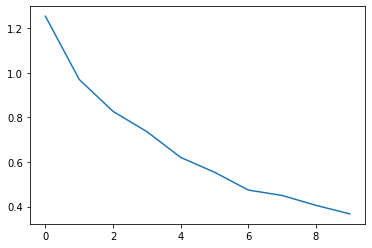

In [14]:
plt.plot(history.history['loss'])

In [15]:
model.evaluate(test_data_gen)


47/47 [==============================] - 108s 2s/step - loss: 0.4514 - accuracy: 0.8480


[0.45136770606040955, 0.8479999899864197]

In [16]:
model.save('landscape_model.h5')